# Homework nr. 3 - features transformation & selection (deadline 13/12/2018)

In short, the main task is to play with transformations and feature selection methods in order to obtain the best results for linear regression model predicting house sale prices.
  
> The instructions are not given in details: It is up to you to come up with ideas on how to fulfill the particular tasks as best you can. ;)

## What are you supposed to do

Your aim is to optimize the _RMSLE_ (see the note below) of the linear regression estimator (=our prediction model) of the observed sale prices.

### Instructions:

  1. Download the dataset from the course pages (hw3_data.csv, hw3_data_description.txt). It corresponds to [this Kaggle competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).
  2. Split the dataset into train & test part exactly as we did in the tutorial.
  3. Transform the features properly (don't forget the target variable).
  4. Try to find the best subset of features.
  5. Compare your results with the [Kaggle leaderboard](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/leaderboard). You should be able to reach approximately the top 20% there.
  
Give comments on each step of your solution, with short explanations of your choices.

  
**Note**: _RMSLE_ is a Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sale prices.


## Comments

  * Please follow the instructions from https://courses.fit.cvut.cz/MI-PDD/homeworks/index.html.
  * If the reviewing teacher is not satisfied, he can give you another chance to rework your homework and to obtain more points.

## Answers

### 2) Split the dataset into train & test part exactly as we did in the tutorial.


In [255]:
import numpy as np
import pandas as pd

from scipy import stats, optimize

from sklearn import model_selection, linear_model, metrics, preprocessing, feature_selection

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [256]:
#importing the CSV that we will be working with and then looking at the data it contains
pd.options.display.max_columns = None
data = pd.read_csv('hw3_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

#### Before splitting that dataset, it should be cleaned first.
This is what we are going to do in the following cells.

In [257]:
# As it has been done in the tutorial, we are going to convert all object values to categorical format
data[data.select_dtypes(include=['object']).columns] = data.select_dtypes(include=['object']).apply(pd.Series.astype, dtype='category')
# Then we fill all the NaN with 0
data.loc[:,data.select_dtypes(include=['float64']).columns] = data.loc[:,data.select_dtypes(include=['float64']).columns].fillna(0)

In [258]:
data.columns[data.isnull().any()]
# df.select_dtypes(include=['category']).columns

# Convert categorical variables to indicators and create new data
data = pd.get_dummies(data)

# check that there are no missings now
print("Are there any missing values :", data.isnull().any().any())

#Let us also convert all non-indicator values to float64 - which would be useful later.
data[data.select_dtypes(['float16', 'float64', 'int64']).columns] = data[data.select_dtypes(['float16', 'float64', 'int64']).columns].astype('float64')

data.dtypes.value_counts()

Are there any missing values : False


uint8      252
float64     38
dtype: int64

In [259]:
# Let us create new features as square roots of Area features - i.e. so they correspond to diameters of circles having the same area
# We also add indicators of zero values (usually missings) there
for column in data.filter(regex='Area|SF', axis=1).columns:  # SF - square foot which means area
    data['Has' + column] = (data[column] > 0).replace({True: 1, False: 0}).astype('uint8')
    data['Sqrt' + column] = np.sqrt(data[column])

print('Shape of the data:', data.shape)

Shape of the data: (1460, 320)


In [260]:
# See the results for Area features
data[data.filter(regex='Area', axis=1).columns].head()

,LotArea,MasVnrArea,GrLivArea,GarageArea,PoolArea,HasLotArea,SqrtLotArea,HasMasVnrArea,SqrtMasVnrArea,HasGrLivArea,SqrtGrLivArea,HasGarageArea,SqrtGarageArea,HasPoolArea,SqrtPoolArea
0,8450.0,196.0,1710.0,548.0,0.0,1,91.923882,1,14.000000,1,41.352146,1,23.409400,0,0.0
1,9600.0,0.0,1262.0,460.0,0.0,1,97.979590,0,0.000000,1,35.524639,1,21.447611,0,0.0
2,11250.0,162.0,1786.0,608.0,0.0,1,106.066017,1,12.727922,1,42.261093,1,24.657656,0,0.0
3,9550.0,0.0,1717.0,642.0,0.0,1,97.724101,0,0.000000,1,41.436699,1,25.337719,0,0.0
4,14260.0,350.0,2198.0,836.0,0.0,1,119.415242,1,18.708287,1,46.882833,1,28.913665,0,0.0


In [261]:
# Remove constant features
display(data.columns[data.min() == data.max()])
data = data[data.columns[data.min() != data.max()]]

Index(['HasLotArea', 'Has1stFlrSF', 'HasGrLivArea'], dtype='object')

In [262]:
# Lets apply a logarithm on the SalePrice feature so that we will be able to see the repartition better when plotting it but also get values lower than 1 for RMSE.
data['SalePrice'] = np.log(data['SalePrice'])

<function matplotlib.pyplot.show(*args, **kw)>

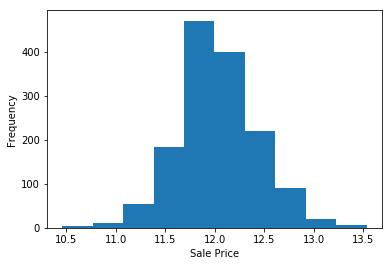

In [263]:
plt.hist(data['SalePrice'])
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.show

In [264]:
# Now that the dataset has been cleaned, as it has been done in the tutorial, now we can split it.
dt, dv = model_selection.train_test_split(data, test_size=0.25, random_state=17)
dt = dt.copy()
dv = dv.copy()
print('Train: ', len(dt), '; Validation: ', len(dv))

Train:  1095 ; Validation:  365


In [265]:
# Since the main task is to obtain better results for the linear regression model, we won't be using the ridge one.

def linreg(train, validate, plot = False, train_error = True):
    # Data prepare
    X = train.drop(['SalePrice'], axis = 1, errors = 'ignore')
    y = train.SalePrice
    Xv = validate.drop(['SalePrice'], axis = 1, errors = 'ignore')
    yv = validate.SalePrice
    
    # Linear Regression train
    clf = linear_model.LinearRegression()
    clf.fit(X, y) 
    
    # Print RMSE
    print('Linear regression root mean squared validation error:', 
          np.sqrt(metrics.mean_squared_error(clf.predict(Xv),yv)))
    if train_error:
        print('Linear regression root mean squared train error:', 
              np.sqrt(metrics.mean_squared_error(clf.predict(X), y)))
    
    # Joint Plot
    if plot:
        sns.jointplot(yv, clf.predict(Xv))

In [266]:
# Run both models
linreg(dt, dv)

Linear regression root mean squared validation error: 0.126395492144322
Linear regression root mean squared train error: 0.08436294175593727


### 3) Transform the features properly (don't forget the target variable).

Here we will standardize features in order to make them more comparable.

In [267]:
# Standardization
standard_scaler = preprocessing.StandardScaler()

# we rescale only numeric values - not indicators
columns = columns.drop('SalePrice', errors = 'ignore')

# Prepare values for the transformation
columns = dt.select_dtypes(include=['float64']).columns 
standard_scaler.fit(dt[columns])


# Standardization
dt_s = dt.copy()
dv_s = dv.copy()
dt_s[columns] = standard_scaler.transform(dt[columns])
dv_s[columns] = standard_scaler.transform(dv[columns])

linreg(dt_s, dv_s)

print("\nHere we are facing the same problem that in the tutorial.\nThe feature transformation using standardization make the linear regression results a lot worse.")
print("Normalization make it even worse than standardization.")

Linear regression root mean squared validation error: 840696132.4387617
Linear regression root mean squared train error: 0.21081833885489265

Here we are facing the same problem that in the tutorial.
The feature transformation using standardization make the linear regression results a lot worse.
Normalization make it even worse than standardization.


### 4) Finding the best subset of features.
In order to find the best subset of features we will use the correlation approach.

In [268]:
# Drop Id - we will store all features to drop in the columns_to_remove list
columns_to_remove = ['Id']

# Correlation matrix Pearson & Spearman
corrP = dt.drop(columns_to_remove, axis = 1, errors = 'ignore').corr(method='pearson')
corrS = dt.drop(columns_to_remove, axis = 1, errors = 'ignore').corr(method='spearman')

# Pearson top 10 with target
corrP_cols = corrP.SalePrice.abs().nlargest(10).index
display(corrP.SalePrice.loc[corrP_cols])
# Spearman top 10 with target
corrS_cols = corrS.SalePrice.abs().nlargest(10).index
display(corrS.SalePrice.loc[corrS_cols])

SalePrice         1.000000
OverallQual       0.820700
SqrtGrLivArea     0.720602
GrLivArea         0.694166
GarageCars        0.689327
GarageArea        0.653478
SqrtGarageArea    0.625460
Sqrt1stFlrSF      0.616300
TotalBsmtSF       0.609998
1stFlrSF          0.601991
Name: SalePrice, dtype: float64

SalePrice         1.000000
OverallQual       0.810410
GrLivArea         0.735184
SqrtGrLivArea     0.735184
GarageCars        0.694128
GarageArea        0.648908
SqrtGarageArea    0.648908
YearBuilt         0.644751
FullBath          0.642719
GarageYrBlt       0.632785
Name: SalePrice, dtype: float64

In [278]:
# One can remove those with correlation smaller than some treshold.
additional_columns = list(corrP.SalePrice[corrP.SalePrice.abs() < 0.01].index)
print(additional_columns)

# extend columns_to_remove
columns_to_remove = list(set(columns_to_remove + additional_columns))

['BsmtHalfBath', 'RoofMatl_ClyTile', 'RoofMatl_Tar&Grv', 'Exterior1st_Plywood', 'Foundation_Stone', 'BsmtFinType2_Rec', 'GarageCond_Gd', 'MiscFeature_Gar2', 'SaleType_CWD', 'SaleType_ConLI', 'SaleCondition_Alloca', 'SqrtBsmtFinSF2']


In [279]:
# Final removal from all datasets
dt.drop(columns_to_remove, axis = 1, errors = 'ignore', inplace=True)
dv.drop(columns_to_remove, axis = 1, errors = 'ignore', inplace=True)
dt_s.drop(columns_to_remove, axis = 1, errors = 'ignore', inplace=True)
dv_s.drop(columns_to_remove, axis = 1, errors = 'ignore', inplace=True)
dt_m.drop(columns_to_remove, axis = 1, errors = 'ignore', inplace=True)
dv_m.drop(columns_to_remove, axis = 1, errors = 'ignore', inplace=True)
dt.shape

(1095, 304)

In [280]:
linreg(dt, dv)

Linear regression root mean squared validation error: 0.12381540153109069
Linear regression root mean squared train error: 0.08481489069731872


### 5) Compare your results with the Kaggle leaderboard. You should be able to reach approximately the top 20% there.